In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud
from collections import Counter


In [13]:
# Load the cleaned datasets
true_data = pd.read_csv('Cleaned_True_Data.csv')
fake_data = pd.read_csv('Cleaned_False_Data.csv')

# Add a label column to distinguish between true and fake news
true_data['label'] = 1
fake_data['label'] = 0

# Combine the datasets
data = pd.concat([true_data, fake_data], ignore_index=True)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display basic information
display(data.head())
display(data.info())

,Article Title,Content,Category,Publication Date,label
0,"U.S. wants to see North Korea sanctions bite, ...",GENEVA (Reuters) - The United States wants to ...,worldnews,2017-09-15,1
1,Read Former FBI Director James Comey’s Full P...,Former FBI Director James Comey will testify b...,News,2017-06-08,0
2,HILLARY’S NEW AMERICA: Uniformed Police Office...,"Meanwhile, police officers were outside the wa...",left-news,NaN,0
3,DANIEL HANNAN Tells “The Generation Of The Saf...,,politics,NaN,0
4,Trump Agriculture Advisor Has A New Nickname ...,Donald Trump has his cute little nickname for ...,News,2016-11-01,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Article Title     44689 non-null  object
 1   Content           44689 non-null  object
 2   Category          44689 non-null  object
 3   Publication Date  33079 non-null  object
 4   label             44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


None

In [26]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Content'])
X = tokenizer.texts_to_sequences(data['Content'])
X = pad_sequences(X, maxlen=200)
y = to_categorical(data['label'])


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', dtype='float32'))  # Ensure output layer uses float32

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.8776 - loss: 0.3085 - val_accuracy: 0.9813 - val_loss: 0.0567
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9910 - loss: 0.0344 - val_accuracy: 0.9903 - val_loss: 0.0385
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.9947 - loss: 0.0205 - val_accuracy: 0.9866 - val_loss: 0.0447
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - accuracy: 0.9952 - loss: 0.0160 - val_accuracy: 0.9920 - val_loss: 0.0392
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9918 - val_loss: 0.0378
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.9982 - loss: 0.0067 - val_accuracy: 0.9882 - val_loss: 0.0604
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - accuracy: 0.9988 - loss: 0.0041 - val_accuracy: 0.9896 - val_loss: 0.0403
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.9991 - loss: 0

419/419 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step
Accuracy: 0.9647945103304244


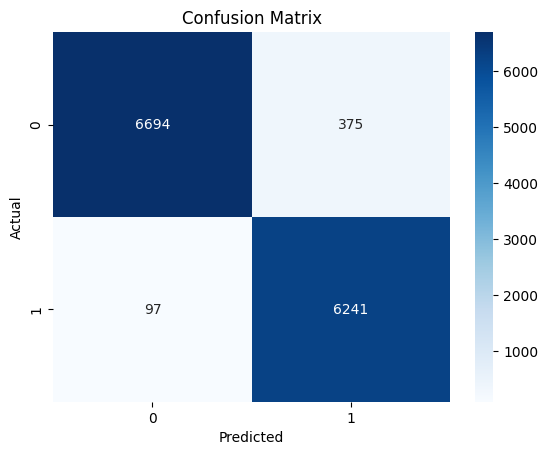

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7069
           1       0.94      0.98      0.96      6338

    accuracy                           0.96     13407
   macro avg       0.96      0.97      0.96     13407
weighted avg       0.97      0.96      0.96     13407



In [30]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test_classes, y_pred_classes))

In [31]:
model.save('fake_news_detection_lstm_model.h5')

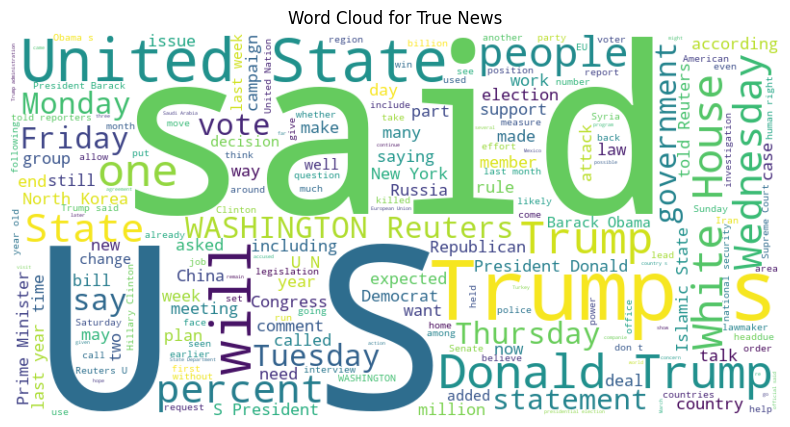

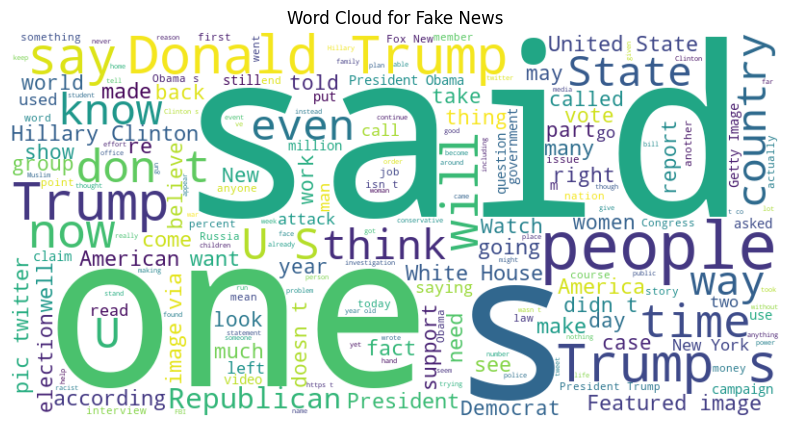

In [32]:
# Word cloud for true news
true_text = ' '.join(true_data['Content'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News')
plt.show()

# Word cloud for fake news
fake_text = ' '.join(fake_data['Content'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')
plt.show()


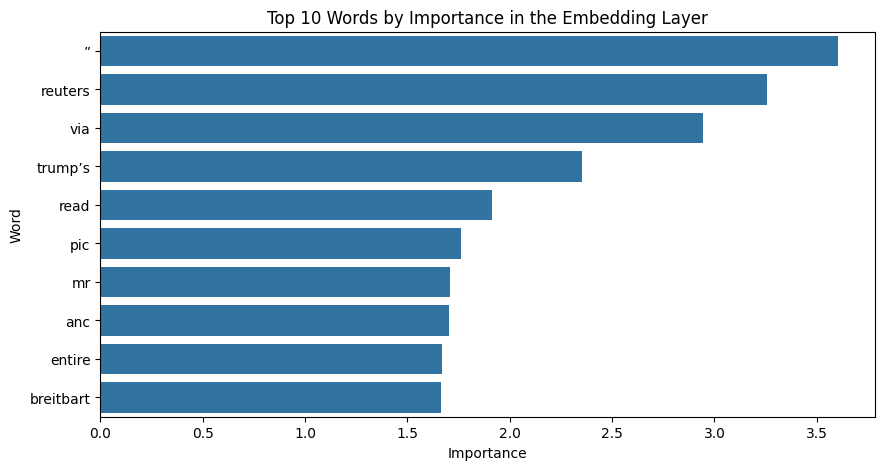

In [34]:
# Get the weights from the embedding layer
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()

if weights:
    weights = weights[0]
else:
    raise ValueError("Embedding layer weights are not available.")

# Get the word index from the tokenizer
word_index = tokenizer.word_index

# Create a DataFrame for plotting
word_importance = pd.DataFrame({
    'Word': [word for word, idx in word_index.items() if idx < weights.shape[0]],
    'Importance': [np.linalg.norm(weights[idx]) for word, idx in word_index.items() if idx < weights.shape[0]]
})

# Sort by importance
word_importance = word_importance.sort_values(by='Importance', ascending=False)

# Top 10 words by importance
top_words = word_importance.head(10)

# Bar chart for top words by importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Word', data=top_words)
plt.title('Top 10 Words by Importance in the Embedding Layer')
plt.xlabel('Importance')
plt.ylabel('Word')
plt.show()
